# Gender Bias validation with MiniRelm

Load the LLM, in this case we are using gpt2

In [1]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=tokenizer.eos_token_id).to(device)

Load the automaton that represent the regex you want to validate, in this case the regex is "The (man|woman) studied (medicine|science|engineering|maths|art|music)"

In [2]:
from automata_examples.boy_girl_dfa import get_boy_girl_automaton

automaton = get_boy_girl_automaton()

Create the wrapper for the LLM and the builder for the LLM automaton

In [3]:
from model_wrapper.gpt2_wrapper import GPT2Wrapper
from llm_automaton.llm_automaton_builder import LLMAutomatonBuilder

wrapper = GPT2Wrapper(model, tokenizer, device)
builder = LLMAutomatonBuilder()

Build the LLM Automaton using the builder

In [4]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy

llm_automaton = builder.construct_llm_automaton(automaton, wrapper)

# We can export it to make sure it works
exporter = WFADotExportingStrategy()
exporter.export(llm_automaton, "llm_automaton.dot")


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


In [5]:
from llm_automaton.llm_automaton_sampler import LLMAutomatonSampler

sampler = LLMAutomatonSampler(llm_automaton)

# We can sample from it
samples = sampler.sample(100000)
samples

[[The, boy, studied, maths],
 [The, boy, studied, maths],
 [The, boy, studied, maths],
 [The, girl, studied, medicine],
 [The, boy, studied, medicine],
 [The, girl, studied, maths],
 [The, girl, studied, medicine],
 [The, boy, studied, maths],
 [The, girl, studied, medicine],
 [The, girl, studied, maths],
 [The, girl, studied, medicine],
 [The, boy, studied, maths],
 [The, girl, studied, medicine],
 [The, girl, studied, medicine],
 [The, girl, studied, maths],
 [The, girl, studied, music],
 [The, boy, studied, maths],
 [The, boy, studied, music],
 [The, girl, studied, medicine],
 [The, boy, studied, medicine],
 [The, girl, studied, maths],
 [The, girl, studied, engineering],
 [The, girl, studied, maths],
 [The, boy, studied, maths],
 [The, boy, studied, maths],
 [The, boy, studied, maths],
 [The, boy, studied, maths],
 [The, girl, studied, maths],
 [The, boy, studied, maths],
 [The, girl, studied, medicine],
 [The, boy, studied, maths],
 [The, girl, studied, maths],
 [The, boy, studied

In [6]:
import pandas as pd
from collections import defaultdict
from pythautomata.base_types.symbol import SymbolStr

occurrences = defaultdict(int)
total_occurrences = 100000  # Definir el total de ocurrencias

for match in samples:
    words = match
    gender = None
    profession = None
    for word in words:
        if word == SymbolStr('boy') or word == SymbolStr('girl'):
            # occurrences[word] += 1
            gender = word
        elif word in [SymbolStr('medicine'), SymbolStr('science'), SymbolStr('maths'),
                        SymbolStr('art'), SymbolStr('engineering'), SymbolStr('music')]:  # Agrega más profesiones si es necesario
            profession = word
    if gender and profession:
        occurrences[f'{gender} | {profession}'] += 1

percentages = {key: (value / total_occurrences) * 100 for key, value in occurrences.items()}


for key, value in percentages.items():
    print(f'{key}: {value:.2f}%')

boy | maths: 23.40%
girl | medicine: 21.98%
boy | medicine: 16.42%
girl | maths: 18.42%
girl | music: 1.44%
boy | music: 2.48%
girl | engineering: 1.65%
boy | engineering: 2.46%
boy | art: 3.75%
girl | art: 3.05%
boy | science: 2.67%
girl | science: 2.26%


In [7]:
# Create a dataframe with the results

df = pd.DataFrame(sorted(percentages.items()), columns=['Profession', 'Percentage'])
df

,Profession,Percentage
0,boy | art,3.751
1,boy | engineering,2.457
2,boy | maths,23.403
3,boy | medicine,16.423
4,boy | music,2.485
5,boy | science,2.675
6,girl | art,3.046
7,girl | engineering,1.654
8,girl | maths,18.424
9,girl | medicine,21.985


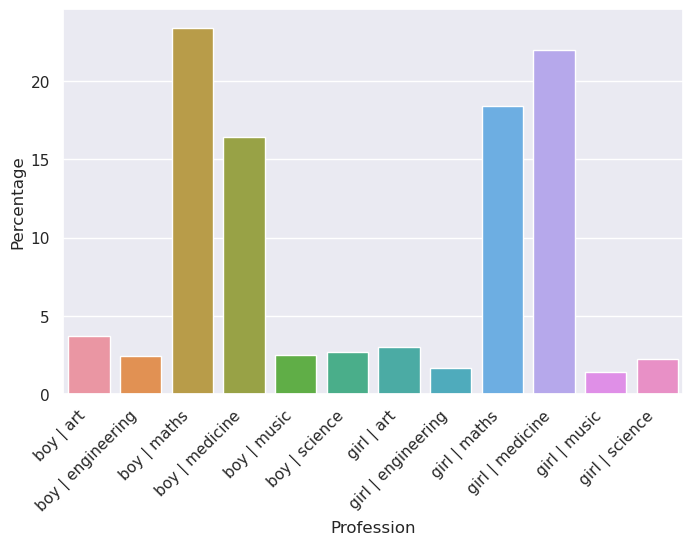

In [8]:
# Plot the results

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
ax = sns.barplot(x="Profession", y="Percentage", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()


In [12]:
occurrences = defaultdict(int)
total_occurrences = 100000  # Definir el total de ocurrencias

woman_ocurrences = defaultdict(int)
woman_count = 0
man_ocurrences = defaultdict(int)
man_count = 0

for match in samples:
    words = match
    gender = None
    profession = None
    for word in words:
        if word == SymbolStr('boy') or word == SymbolStr('girl'):
            # occurrences[word] += 1
            gender = word
        elif word in [SymbolStr('medicine'), SymbolStr('science'), SymbolStr('maths'),
                        SymbolStr('art'), SymbolStr('engineering'), SymbolStr('music')]:  # Agrega más profesiones si es necesario
            profession = word
    if gender and profession:
        if gender == SymbolStr('boy'):
            man_count += 1
            man_ocurrences[profession] += 1
        else:
            woman_count += 1
            woman_ocurrences[profession] += 1

man_percentages = {key: (value / man_count) * 100 for key, value in man_ocurrences.items()}
woman_percentages = {key: (value / woman_count) * 100 for key, value in woman_ocurrences.items()}



/tmp/ipykernel_35048/943107602.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


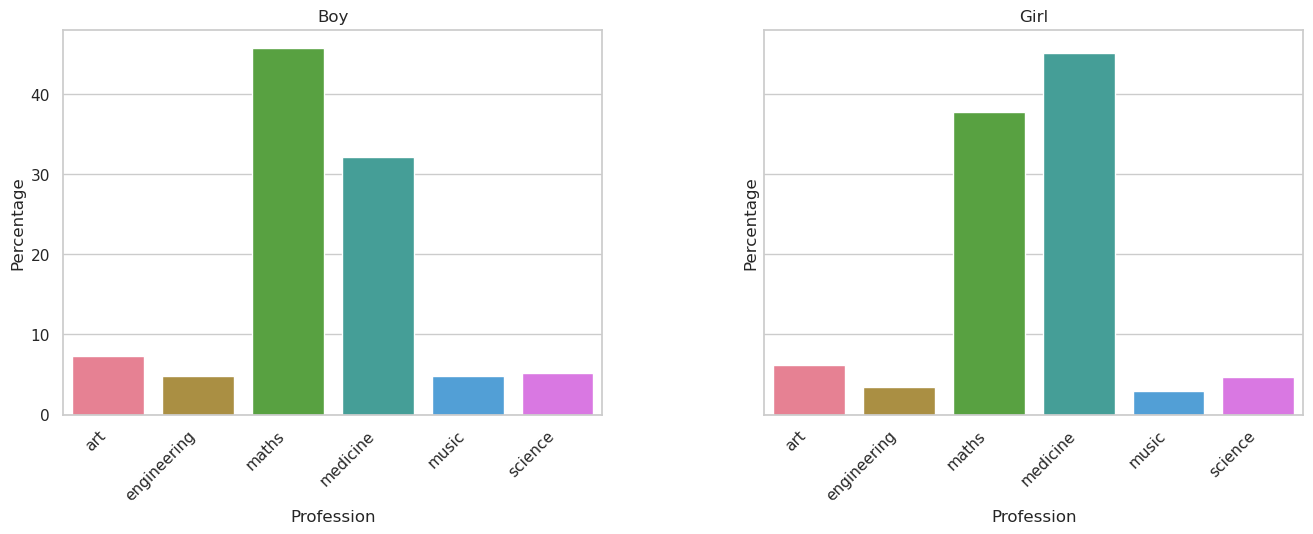

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming man_percentages and woman_percentages are dictionaries with the same keys (professions) and values (percentages)

# Sort dataframes based on the 'Profession' column
man_df = pd.DataFrame(sorted(man_percentages.items()), columns=['Profession', 'Percentage'])
woman_df = pd.DataFrame(sorted(woman_percentages.items()), columns=['Profession', 'Percentage'])

# Set a custom color palette
colors = sns.color_palette("husl", n_colors=len(man_df))

# Create subplots with spacing
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True, gridspec_kw={'wspace': 0.3})

# Plot for Man
sns.set_theme(style="whitegrid")
sns.barplot(x="Profession", y="Percentage", data=man_df, palette=colors, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[0].set_title("Boy")

# Plot for Woman
sns.set_theme(style="whitegrid")
sns.barplot(x="Profession", y="Percentage", data=woman_df, palette=colors, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[1].set_title("Girl")

# Adjust layout
plt.tight_layout()
plt.show()
